# computing error of linear particle annihilation rate to that of the full models (gpu-accelerated)
Tim Tyree<br>
9.12..2022

In [1]:
from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import minimize
#load libraries for color bar
import matplotlib as mpl #for colorbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [4]:
def recall_death_rates_vidmar_rappel(data_fk_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_tt.csv',
                                     data_lr_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_tt.csv',**kwargs):
    """
    Example Usage:
dict_wjr = recall_death_rates_vidmar_rappel()
print(*dict_wjr)
model_str = 'fk_pbc'
# model_str = 'lr_pbc'
print_dict(dict_wjr['wjr'][model_str])
    """
    #recall powerlaw fits to full
    wjr=recall_powerlaw_fits_to_full_models()
    # #recall annihilation rate results from vidmar and rappel (2019)
    fk=pd.read_csv(data_fk_dir)
    fk['N']=fk['No2']*2
    fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
    fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2
    lr=pd.read_csv(data_lr_dir)
    lr['N']=lr['No2']*2
    lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
    lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2
    
    #evaluate min/max particle density observed
    qlim_fk =  [np.min(fk['q']),np.max(fk['q'])]
    qlim_lr =  [np.min(lr['q']),np.max(lr['q'])]
    dict_wjr=dict(wjr=wjr,fk=fk,lr=lr,qlim_fk=qlim_fk,qlim_lr=qlim_lr)
    return dict_wjr

In [5]:
def plot_death_rates_loglog_full(fk,lr,ax=None,
                                x1lim = [8e-3, 11],  #[8e-2, 1.1],  #[1e-1, 1] # [5,10]
                                x2lim = [1e-2, 250],  #[1e-2, 25], #[50,350]
                                legend_alpha=1.,
                                alpha=0.2,
                                s=40,
                                fontsize=18,
                                use_loglog=True,
                                frameon_legend=False,
                                zorder=0,**kwargs):
    """
    Example Usage:
ax = plot_death_rates_loglog_full(fk,lr,ax)
    """
    if ax is None:
        ax = plt.gca()
    #plot the full models
    ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=alpha,s=s,label='Fenton-Karma',zorder=zorder)
    ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=alpha,s=s,label='Luo-Rudy',zorder=zorder)
    #format
    FormatAxes(
        ax=ax,
        x1lim=x1lim,
        x2lim=x2lim,
        x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
        x2label=
        r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
        title=None,
        fontsize=fontsize,
        use_loglog=use_loglog)
    format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize,use_loglog=use_loglog,**kwargs)
    leg=ax.legend(loc='lower right',fontsize=fontsize,frameon=frameon_legend)
    for lh in leg.legendHandles: 
        lh.set_alpha(legend_alpha)
    return ax

In [6]:
def comp_log_likelihood_ols(se_values,
                            s = None, #input parameter
                            **kwargs):
    """comp_log_likelihood_ols computes log_likelihood for linear regression 
    evaluated at the closed-form maximum likelhood estimator from Eqn. 1-3 from src.  
    If posterior root variance, s, is None, then s is set to the apparent 
    root mean squared error (rmse), which is the mle of s for the ols prior.
            
    src: https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf/

    Example Usage:
se_values = (np.log(w_values)-np.log(what_values))**2
ll = comp_log_likelihood_ols(se_values)
    """
    n = se_values.shape[0]
    if s is None:
        s = np.sqrt(np.mean(se_values)) # float(rmse) # 
    ll  = - 0.5*n*np.log(2.*np.pi)
    ll -= n*np.log(s)
    ll -= np.sum(se_values)/(2.*s**2)
    return ll

In [7]:
def comp_defect_mean_annihil_rate(df, qlim_full, fit_full, **kwargs):
    """comp_defect_mean_annihil_rate computes the error of w(q) in df to full.
    dict_linear contains the boundaries of df intersected with full as the effective qmin,qmax.
    the linear defects at the boundary are evaluated (emin,emax) in addition to the log defects (lemin,lemax).
    defects computed include the root mean squared error (rmse) and the log-likelihood.
    if parameter s is not specified, then s is taken to be the mle for the ols prior.
    
    Example Usage:
dict_defects = comp_defect_mean_annihil_rate( df, qlim_full, fit_full)
    """
    #inputs: df, qlim_full, fit_full, 
    #outputs: 
    #compute the maximal intersection of the explanatory variable, q
    qmin = np.max((df['q'].min(),qlim_full[0]))
    qmax = np.min((df['q'].max(),qlim_full[1]))
    #constrain boundary evaluate to the closest interior points simulated value for q at either bound
    qmin = df.loc[df['q']>=qmin,'q'].min()
    qmax = df.loc[df['q']<=qmax,'q'].max()
    #constrain to the interior
    boo  = (df['q']>=qmin)&(df['q']<=qmax)
    q_values = df[boo]['q'].values
    w_values = df[boo]['w'].values
    #evaluate the full model powerlaw fit
    what_values = fit_full['M']*(q_values**fit_full['m'])
    #evaluate boundary and compute rmse
    e_values = w_values-what_values
    emin = float(e_values[q_values==qmin])
    emax = float(e_values[q_values==qmax])
    num_obs = w_values.shape[0]
    #compute rmse
    rmse = np.sqrt(np.mean((e_values)**2))
    #evaluate boundary and compute log-likelihood
    le_values = np.log(w_values/what_values)
    lemin = float(e_values[q_values==qmin])
    lemax = float(e_values[q_values==qmax])
    #compute log-likelihood / negative mutual information / negative entropy
    ll = comp_log_likelihood_ols(le_values**2,**kwargs)

    dict_defects = dict(num_obs=num_obs,qmin=qmin,qmax=qmax,
                        rmse=rmse,log_likelihood=ll,
                       emin=emin,emax=emax,lemin=lemin,lemax=lemax)
    return dict_defects

In [8]:
def routine_measure_annihilation_defect(input_fn,**kwargs):
    """returns tuple of the pandas.DataFrameinstance read from input_fn
    along with associated dictionary, dict_linear.
    dict_linear contains the error of linear/powerlaw fit to full pair-annihilation rates
    kwargs are directly passed to recall_death_rates_vidmar_rappel
    in addition to being passed to comp_defect_mean_annihil_rate directly.
    
    Example Usage:
df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
    """
    df=pd.read_csv(input_fn)
    #parse input_fn for unique identifier
    lst = input_fn.split('.')
    cluster_index=eval(lst[-2])
    job_index=eval(lst[-1])
    #compute w,q and add as fields to df
    df['q']=df['N']/(df['L']**2)
    df['w']=(df['CollTime']**-1)/(df['L']**2)
    #parse input_fn for unique identifier
    lst = input_fn.split('.')
    cluster_index=eval(lst[-2])
    job_index=eval(lst[-1])
    #recall annihilation rates from full model
    dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
    fk=dict_wjr['fk']
    lr=dict_wjr['lr']
    #determine a reasonable qmin,qmax
    dict_linear=dict(cluster_index=cluster_index,job_index=job_index,
            dict_min = dict(df.min()),
            dict_max = dict(df.max()),
    )
    #compute defects for either of the full models
    for model_str in ['fk','lr']:
        qlim_full = dict_wjr[f'qlim_{model_str}']
        fit_full = dict_wjr['wjr'][f"{model_str}_pbc"]
        #compute defect
        dict_defects = comp_defect_mean_annihil_rate( df, qlim_full, fit_full,**kwargs)
        dict_linear[f"dict_defects_{model_str}"]=dict(dict_defects)
    return df,dict_linear


In [9]:
def dict_compare(d1, d2):
    """dict_compare returns a tuple of sets containing keys to dict1 or dict2.
    
    Example Usage:
added, removed, modified, same = dict_compare(d1=dict(a=1, b=2), d2=dict(a=2, b=2))
added, removed, modified, same
"""
    d1_keys  = set(d1.keys())
    d2_keys  = set(d2.keys())
    shared_keys = d1_keys.intersection(d2_keys)
    added    = d1_keys - d2_keys
    removed  = d2_keys - d1_keys
    modified = {o : (d1[o], d2[o]) for o in shared_keys if d1[o] != d2[o]}
    same = set(o for o in shared_keys if d1[o] == d2[o])
    return added, removed, modified, same

def parse_dict_linear_to_row(dic):
    """
    Example Usage:
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear)
    """
    added, removed, modified, same = dict_compare(dic['dict_min'],dic['dict_max'])
    #test for equality of keys
    assert set()==added
    assert set()==removed
    #test exactly the right keys are equal in the dictionary
    assert same=={'D','Dt','L','dt','force_code','kappa','neighbor','niter','no_attraction','no_repulsion','r','reflect','set_second','varkappa','x0'}

    dict_defects_fk = dict(dic['dict_defects_fk'])
    dict_defects_lr = dict(dic['dict_defects_lr'])
    #wlog, map same values in dict_min to dict_defects_...
    dict_min=dic['dict_min']
    for key in same:
        dict_defects_fk[key]=dict_min[key]
        dict_defects_lr[key]=dict_min[key]
    #for modified values, map them to ..._lo,_hi fields
    for key in modified:
        vlim=modified[key]
        dict_defects_fk[f"{key}_lo"]=vlim[0]
        dict_defects_fk[f"{key}_hi"]=vlim[1]
        dict_defects_lr[f"{key}_lo"]=vlim[0]
        dict_defects_lr[f"{key}_hi"]=vlim[1]
    #set the unique identifier index fields
    dict_defects_fk['cluster_index']=dic['cluster_index']
    dict_defects_fk['job_index']=dic['job_index']
    dict_defects_lr['cluster_index']=dic['cluster_index']
    dict_defects_lr['job_index']=dic['job_index']
    return dict_defects_fk,dict_defects_lr


# DONE: developed routine for generating a really big pandas.DataFrame instance before attempting to aggregate it into one spot
- TODO: use it over dask with 100 tasks
- TODO: use it over dask with 1000 tasks
- TODO: use it over dask with all available tasks

__log-likliehood for linear regression:__

$$
L(b_0,b_1,s^2) = \log \Pi_{i=1}^n p(y_i | x_i; b_0,b_1,s^2)
$$
$$...$$
$$
L(b_0,b_1,s^2) = -\frac{n}{2}\log 2\pi - n\log s -\frac{1}{2s^2}\sum_{i=1}^n(y_i - (b_0 +b_1x_i))^2
$$

maximum likelihood estimate of s is the root mean squared error, (RMSE). <br> src: `https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf/`.

In [36]:
#load the final file listed in a run folder
run_num=26
printing=True
input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
os.chdir(input_folder)
task_lst = [os.path.abspath(input_fn) for input_fn in os.listdir()]
if printing:
    print(f"added {len(task_lst)} tasks to queue!")

added 140775 tasks to queue!


In [9]:
testing=True
if testing:
    input_fn = task_lst[0]
    df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
    if printing:
        print(f"computed defect for mean annihilation rates of {dict_linear['job_index']=} in {dict_linear['cluster_index']=}:")
        col_lst=['varkappa','D','r','kappa','L']
        for col in col_lst:
            val=df[col].min()
            print(f"{col}: {val}")
        print(F"{df.shape=}")
        print(f"\nkeys available in dict_linear:")
        print(*dict_linear)
        print(f"apparent defects/errors:")
        print(f"rmse_fk: {dict_linear['dict_defects_fk']['rmse']:.4f}")
        print(f"loglik_fk: {dict_linear['dict_defects_fk']['log_likelihood']:.4f}")
        print(f"rmse_lr: {dict_linear['dict_defects_lr']['rmse']:.4f}")
        print(f"loglik_lr: {dict_linear['dict_defects_lr']['log_likelihood']:.4f}")

computed defect for mean annihilation rates of dict_linear['job_index']=50567 in dict_linear['cluster_index']=23278799:
varkappa: 2.64
D: 0.125
r: 0.085
kappa: 340
L: 5
df.shape=(95, 19)

keys available in dict_linear:
cluster_index job_index dict_min dict_max dict_defects_fk dict_defects_lr
apparent defects/errors:
rmse_fk: 1.4532
loglik_fk: -8.1187
rmse_lr: 2.8923
loglik_lr: -16.1483


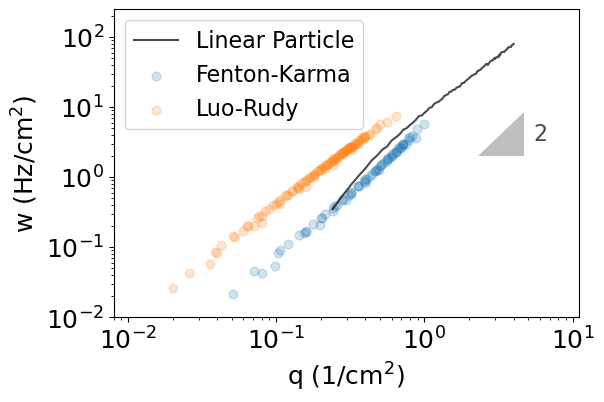

In [33]:
#plot the original annihilation rates
dict_wjr = recall_death_rates_vidmar_rappel()
fk=dict_wjr['fk']
lr=dict_wjr['lr']
figsize = (6, 4)  #(5,4)
fontsize=18
if testing:
    fig, ax = plt.subplots(figsize=figsize)
    df.plot(x='q',y='w',alpha=0.7,ax=ax,color='black',label='Linear Particle')
    ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize)
    ax.legend(loc='upper left',fontsize=fontsize-2)
    #add annotation
    # xy=(0.3, 11)
    # xytext=(0.09, 10)
    #ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
    #add marker showing the slope of ~2
    annotation.slope_marker(origin=(2.3, 2.0),
                            slope=2,
                            text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                            poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
                            ax=ax)
    plt.show()

# compute error/defect of a linear particle model annihilation rates wrt the full model

- DONE: Option 1: do it directly in a way that is impenetrable in argument
- DONT: Option 2: do it lazily by copying the solution which i already said is flawed to wjr during our last excellent meeting...
- DONE: evaluate over all such files

In [11]:
def routine(task):
    try:
        input_fn = task
        df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
        #dict_linear['folder'] = os.path.basename(input_fn) #strings are relatively expensive at these scales...
        return dict_linear
    except Exception as e:
        return f"Warning: {e} for {task=}"

In [12]:
use_evaluate_annihilation_defects=False
if use_evaluate_annihilation_defects:
    from dask.distributed import Client, progress
    client = Client(n_workers=4, threads_per_worker=1)
    client

In [60]:
#save the defects as a complicated hierarchical dataset
max_num_jobs=4
printing=True
saving=True
pkl_dir_defects=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_full.pkl'
#optionally, run daskbag
os.chdir(nb_dir)
npartitions=np.min((len(task_lst),max_num_jobs))
if use_evaluate_annihilation_defects:
    if printing:
        print(f"running {len(task_lst)} tasks over {npartitions} cpu cores (140775 tasks over 4 cpu cores took <7.5 minutes)...")
    retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=printing)
    if printing:
        print(f"tasks complete!")
    #format results
    dict_linear_lst=[]
    for rv in retval:
        if type(rv)==type(''):
            print(rv)
        else:
            dict_linear_lst.append(rv)
    if saving:
        pdict=dict(zip(range(len(dict_linear_lst)),dict_linear_lst))
        save_to_pickle(pkl_dir_defects,pdict)
        print(f"saved to\n{pkl_dir_defects=}")

# visually investigate the defects

In [14]:
load_cache=False
if load_cache:
    pkl_dir_defects='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_full.pkl' #~200MB
    pdict=load_from_pickle(pkl_dir_defects)
    num_trials = len(list(pdict.keys()))
    print(f"loaded defects from {num_trials} trials.")

In [66]:
def routine_(task):
    try:
        input_fn = task
        df,dict_linear = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
        #dict_linear['folder'] = os.path.basename(input_fn) #strings are relatively expensive at these scales...
        dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear)
        return dict_defects_fk,dict_defects_lr
    except Exception as e:
        return f"Warning: {e} for {task=}"


In [73]:
#compute the defects as rows for tables
use_generate_annihilation_defect_table=True
if use_generate_annihilation_defect_table:
    from dask.distributed import Client, progress
    client = Client(n_workers=4, threads_per_worker=1)
    print(client)


<Client: 'tcp://127.0.0.1:43285' processes=4 threads=4, memory=62.53 GiB>


In [74]:
#save the defects as a table (parquet is good)
print(f"link to dask dashboard: {client.dashboard_link}")

link to dask dashboard: http://127.0.0.1:44493/status


In [76]:
#save the defects as a complicated hierarchical dataset
max_num_jobs=4
printing=True
saving=True
# parquet_dir_defects=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_full.parquet'
#optionally, run daskbag
os.chdir(nb_dir)
npartitions=np.min((len(task_lst),max_num_jobs))
if use_generate_annihilation_defect_table:
    if printing:
        print(f"running {len(task_lst)} tasks over {npartitions} cpu cores (140775 tasks over 4 cpu cores took <9.5?? minutes)...")
    retval=eval_routine_daskbag(routine_,task_lst,npartitions,printing=printing)
    if printing:
        print(f"tasks complete!")

running 140775 tasks over 4 cpu cores (140775 tasks over 4 cpu cores took <7.5?? minutes)...


/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814/576671410.py:20: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_18814

run time for evaluating routine was 560.62 seconds, yielding 140775 values returned
tasks complete!


In [ ]:
beep(4)

In [85]:
# if use_generate_annihilation_defect_table:
#format results
dict_defects_fk_lst=[]
dict_defects_lr_lst=[]
for rv in retval:
    if type(rv)==type(''):
        print(rv)
    else:
        dict_defects_fk,dict_defects_lr = rv
        dict_defects_fk_lst.append(dict_defects_fk)
        dict_defects_lr_lst.append(dict_defects_lr)
df_defects_fk = pd.DataFrame(dict_defects_fk_lst)
df_defects_lr = pd.DataFrame(dict_defects_lr_lst)

In [83]:
#DONE: save measures as .parquet ~10 MB per full model
if saving:
    parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
    df_defects_fk.to_parquet(parquet_dir_defects_fk)
    parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
    df_defects_lr.to_parquet(parquet_dir_defects_lr)
    print(f"saved to\n{parquet_dir_defects=}")

saved to
parquet_dir_defects='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_full.parquet'


In [84]:
print(f"{parquet_dir_defects_fk=}")
print(f"{parquet_dir_defects_lr=}")

parquet_dir_defects_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_fk.parquet'
parquet_dir_defects_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_lr.parquet'


# TODO: visualize the locus traced by constant amax=alinear+2D and increasing D

In [20]:
parquet_dir_defects_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_fk.parquet'
parquet_dir_defects_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_defects_to_lr.parquet'
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
df_defects_lr.shape

#compute for each member a=amax-2*D
num_digits_round=2
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round)


In [82]:
#DONE: confirmed there are only the original values for amax present
#TODO: identify the lowest error simulation for each amax value
print(f"lower rmse for each amax (FK)")
for amax,g in df_defects_fk.groupby(by='amax'):
    dict_best_fits = dict(amax=amax,
         rmse_min = g['rmse'].min(),
                count = g['rmse'].count()
#          nll_min = -g['log_likelihood'].max()
                         )
    print_dict(dict_best_fits)

lower rmse for each amax (FK)
amax=1.78
rmse_min=0.09057709492737111
count=44391
amax=2.89
rmse_min=0.07137593663617144
count=78321
amax=3.29
rmse_min=0.1463495458311799
count=18060


In [81]:
#DONE: confirmed there are only the original values for amax present
#TODO: identify the lowest error simulation for each amax value
print(f"lower rmse for each amax (LR)")
for amax,g in df_defects_lr.groupby(by='amax'):
    dict_best_fits = dict(amax=amax,
         rmse_min = g['rmse'].min(),
        count = g['rmse'].count()
#          nll_min = -g['log_likelihood'].max()
                         )
    print_dict(dict_best_fits)

lower rmse for each amax (LR)
amax=1.78
rmse_min=2.8312013767099358
count=44391
amax=2.89
rmse_min=1.717015086669923
count=78321
amax=3.29
rmse_min=1.3838283430866074
count=18060


In [29]:
print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)

                r     kappa           D   varkappa       amax         L
min         0.005     200.0       0.050       0.30       1.78       5.0
max         0.200     980.0       1.295       3.19       3.29       5.0
count  140772.000  140772.0  140772.000  140772.00  140772.00  140772.0


# TODO: plot the best fit for either of the full models

In [85]:
#DONE: find best simulation for the FK model so far
cluster_index,job_index = df_defects_fk[df_defects_fk['rmse'] == df_defects_fk['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)

df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_fk)
print(f"best fit for FK has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
# dict_defects_fk

amax=-dict_linear_fit_fk['dict_min']['D']*2+dict_linear_fit_fk['dict_min']['varkappa']
print(f"parameter settings of linear particle model fit to FK ({amax=:.4f}):")
print_dict(dict_linear_fit_fk['dict_min'])
print(f"src: {input_fn}")

best fit for FK has RMSE: 0.0714 (FK), 3.5353 (LR)
parameter settings of linear particle model fit to FK (amax=1.0100):
N=6.0
CollTime=0.000932
r=0.07
D=0.47
L=5.0
kappa=200.0
varkappa=1.95
x0=0.0
dt=1e-05
Dt=1e-05
niter=1500.0
reflect=0.0
set_second=0.0
no_repulsion=0.0
no_attraction=0.0
neighbor=0.0
force_code=2.0
q=0.24
w=0.2500890942398229
src: /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.72520


In [86]:
#DONE: find best simulation for the LR model so far
cluster_index,job_index = df_defects_lr[df_defects_lr['rmse'] == df_defects_lr['rmse'].min()][['cluster_index','job_index']].values.T
input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
assert os.path.exists(input_fn)

df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
dict_defects_fk,dict_defects_lr = parse_dict_linear_to_row(dic = dict_linear_fit_lr)
print(f"best fit for LR has RMSE: {dict_defects_fk['rmse']:.4f} (FK), {dict_defects_lr['rmse']:.4f} (LR)")
dict_defects_fk
amax=-dict_linear_fit_lr['dict_min']['D']*2+dict_linear_fit_lr['dict_min']['varkappa']
print(f"parameter settings of linear particle model fit to LR ({amax=:.4f}):")
print_dict(dict_linear_fit_lr['dict_min'])
print(f"src: {input_fn}")

best fit for LR has RMSE: 8.5081 (FK), 1.3838 (LR)
parameter settings of linear particle model fit to LR (amax=2.9100):
N=6.0
CollTime=5e-05
r=0.2
D=0.095
L=5.0
kappa=920.0
varkappa=3.1
x0=0.0
dt=1e-05
Dt=1e-05
niter=1500.0
reflect=0.0
set_second=0.0
no_repulsion=0.0
no_attraction=0.0
neighbor=0.0
force_code=2.0
q=0.24
w=0.42560435818862785
src: /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.129596


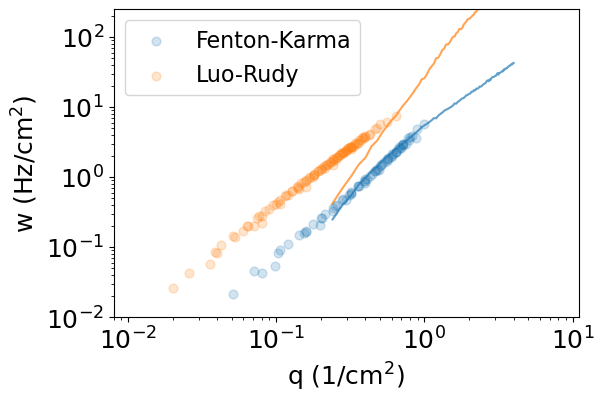

In [87]:
#plot the original annihilation rates
dict_wjr = recall_death_rates_vidmar_rappel()
fk=dict_wjr['fk']
lr=dict_wjr['lr']
figsize = (6, 4)  #(5,4)
fontsize=18
fig, ax = plt.subplots(figsize=figsize)
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='C0',label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='C1',label='_Best Fit to LR')
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize)
ax.legend(loc='upper left',fontsize=fontsize-2)
#add annotation
# xy=(0.3, 11)
# xytext=(0.09, 10)
#ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
#add marker showing the slope of ~2
# annotation.slope_marker(origin=(2.3, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()

# DONE: completed task list

In [18]:
#DONE: (pre)compute w,q from the full model as a lookup table with linear lookups
#DONE: for each row in df,
##DONE: compute the squared error (se) to the FK model
##DONE: compute the squared error (se) to the LR model
#then,
#DONE: wrap ^this into a function from df,wjr to df
#DONE(later, if forloop is slow): daskbag over ^this for a disappointing speedup...
#DONT(later, if cpu is slow): make ^this into a cudf function?
##DONT(prereq): dev wjr_lookup_table from wjr, nah the raw data. looks undeniably like a powerlaw 
##DONT(prereq): test ^this works with Example Usage that computes the rmse to/from the FK/LR model (print a 2x2 matrix)
##DONT: dev chunker / generator / something that returns with yield or yield from.
##DONT: plug ^that into the identity function from df to df
##DONT: modify the identity function to add fields for se_fk and se_lr for each row using wjr_lookup_table

In [ ]:
# df_defects_lr.to_parquet? >>
# See Also
# --------
# read_parquet : Read a parquet file.
# DataFrame.to_csv : Write a csv file.
# DataFrame.to_sql : Write to a sql table.
# DataFrame.to_hdf : Write to hdf.

# TODO(later): dev analysis of powerfits

In [19]:
# b = db.from_delayed([dask.delayed(range)(i) for i in [100000000] * 5])

In [20]:
# printing=True
# if printing:
#     print(f"dict_linear contains the error of linear fit to full pair-annihilation rates:")
#     print_dict(dict_linear)
#     print(f"\npowerlaw data for the {model_str} model:")
#     print(f"{qlim_full=}")
#     print_dict(fit_full)

In [21]:
# powerlaw_fit_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all_powerlaw_fits.csv'
# df=pd.read_csv(powerlaw_fit_dir)
# print (f"{df.shape=}")
# df.head()

In [22]:
# #DONE(preivously): plot given log-file result over the original annihilation rates
# #plot the best fits when a>0
# plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
# plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)


In [23]:
# use_loglog=True
# df.plot.scatter(x='q',y='w',alpha=0.7)
# format_plot(ax=plt.gca(),xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=18,use_loglog=use_loglog)
# plt.xlim([0.1,4])
# plt.ylim([0.1,100])
# # plt.xlim([0.1,1])
# # plt.ylim([0.1,800])
# plt.show()

In [24]:
#DONT: use search_for_file() #demon function! avoid! crashes meh terminal cli!
#DONE: abstracted parsing of attractive output to .csv
# input_folder=f"../data"
# input_fn='example.log'
# os.chdir(input_folder)
# assert (os.path.exists(input_fn))
# df=parse_output_log(input_fn, include_inputs=False, printing=True)
#get last input_fn listed for run_num
